In [1]:
import tweepy
import json
import itertools 
from itertools import islice
import os
import time
import pprint
import requests
import networkx as nx
from networkx.algorithms.approximation import clique
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from pyvis.network import Network
from scipy import stats

print("Librerie caricate!")


Librerie caricate!


In [5]:
data_folder = "data_ids"
pp=pprint.PrettyPrinter()

def serialize_json(folder, filename, data):
    if not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)
    with open(f"{folder}/{filename}", 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False, indent=4)
        f.close()
    print(f"Data serialized to path: {folder}/{filename}")

def read_json(path):
    if os.path.exists(path):
        with open(path, "r", encoding="utf8") as file:
            data = json.load(file)
        print(f"Data read from path: {path}")
        return data
    else:
        print(f"No data found at path: {path}")
        return {}

In [2]:
#Fase di autenticazione
api_key="cvoM8D7hXXxlvBXTM8aH9X2ec"
api_secret="Uk2UvH0FJY7KaDzkXYLfgiYkA1OuCwbLlGFPyodB5wcQ5bsItN"
access_token="3303466053-OLuExo5KcP8UQCVwZwmyakZs8b91Fpl2lMOUDAe"
access_secret="1lMXufu42KN8JvJjYT7c0zI3Q57CkN09BxkNXZuNQ0Dej"
bearer_token="AAAAAAAAAAAAAAAAAAAAAHsVJQEAAAAAQ4vYb83r6ueD8QvjJ4Zpx9R7Kbw%3DQuLzsmDYOvpff7lRHGXhNJSOXTFuPyOwLHZv7HPSj9WF34h1E8"

auth=tweepy.OAuthHandler(api_key,api_secret)
auth.set_access_token(access_token,access_secret)
api=tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)
if(api.verify_credentials):
    print("Auth success")

Auth success


In [3]:
users_screen_name=["mizzaro","damiano10","miccighel_","eglu81","KevinRoitero"]
users_id=[18932422, 132646210, 15750573, 19659370, 3036907250]

In [ ]:
#1. Scaricare gli id dei followers e dei following dei 5 account principali
followers_ids,following_ids={},{}

for utente in users_id:
    print(utente)
    followers_utente,following_utente=[],[]
    for item in tweepy.Cursor(
        api.followers,
        id=utente,
        skip_status=True,
        include_user_entities=False
    ).items():
        json_data=item._json
        user={"id":json_data["id"]}
        time.sleep(181)
        followers_utente.append(user)

    followers_ids[utente]=followers_utente
    

    for item in tweepy.Cursor(
        api.friends,
        id=utente,
        skip_status=True,
        include_user_entities=False
    ).items():
        json_data=item._json
        user={"id":json_data["id"]}
        time.sleep(181)
        following_utente.append(user)

    following_ids[utente]=following_utente

print(following_ids)

#export to json
serialize_json("data_ids","followers_5_utenti.json",followers_ids)
serialize_json("data_ids","following_5_utenti.json",following_ids)

In [ ]:
# 2
#Download dei followers dei 10 followers degli utenti random
followers_ids= []
followers_ids = read_json("data_ids/followers_5_utenti.json")
random_followers_utenti_ids, followers_of_followers_ids = {}, {}

for utente in followers_ids:
    random_followers_utenti_ids[utente] = random.sample(followers_ids[utente], 5)
try:
    for utente in random_followers_utenti_ids:
        for f in random_followers_utenti_ids[utente]:
            fof = []
            print("scarico per " + str(utente))
            for item in tweepy.Cursor(
                    api.followers,
                    id=f['id'],
                    skip_status=True,
                    include_user_entities=False
            ).items(10):
                    time.sleep(10)
                    json_data = item._json
                    user = {"id": json_data["id"]}
                    fof.append(user)
                    print("Downloaded: " + str(user))

            followers_of_followers_ids[f['id']] = fof
except tweepy.TweepError as error: 
    print(error)
serialize_json("data_ids/finale", "followers_of_followers.json", followers_of_followers_ids)

#Download dei following dei 10 following degli utenti random 
following_ids = []
following_ids = read_json("data_ids/following_5_utenti.json")
for utente in following_ids:
    random_following_utenti_ids[utente] = random.sample(following_ids[utente], 5)
# result: random_following_utenti_ids= {"mizzaro":[{}{}{}{}{}],"damiano10":[{}...}],...}
try:
    for utente in random_following_utenti_ids:
        for f in random_following_utenti_ids[utente]:
            fof = []
            print("scarico per " + str(utente))
            for item in tweepy.Cursor(
                    api.friends,
                    id=f['id'],
                    skip_status=True,
                    include_user_entities=False
            ).items(10):
                time.sleep(10)
                json_data = item._json
                user = {"id": json_data["id"]}
                fof.append(user)
                print("Downloaded: " + str(user))

            following_of_following_ids[f['id']] = fof
except tweepy.TweepError as error: 
    print(error)
serialize_json("data_ids/finale", "following_of_following.json", following_of_following_ids)

In [6]:
#Unione di tutti gli id rilevati e rimozione dei duplicati

#Caricamento json contenente tutti gli ID dei nodi interessati
followers_ids=read_json("data_ids/followers_5_utenti.json")
following_ids=read_json("data_ids/following_5_utenti.json")
followers_of_followers_ids=read_json("data_ids/followers_of_followers.json")
following_of_following_ids=read_json("data_ids/following_of_following.json")

print("Json caricati")

lista_json=[followers_ids,following_ids, followers_of_followers_ids,following_of_following_ids]

id_nodi_grafo=[]
#Eliminazione duplicati e conteggio di essi.
for jsonn in lista_json:
    for user in jsonn:
        for user_id in jsonn[user]:
            if not user_id in id_nodi_grafo:
                id_nodi_grafo.append(user_id)

print(len(id_nodi_grafo))


Data read from path: data_ids/followers_5_utenti.json
Data read from path: data_ids/following_5_utenti.json
Data read from path: data_ids/followers_of_followers.json
Data read from path: data_ids/following_of_following.json
Json caricati
3103


In [ ]:
#4 Scaricare i dati di ogni utente con api.get_user 

nodes = {}
    
for user_id in id_nodi_grafo: 
    #richiamo API GET_USER
    utente=api.get_user(id=user_id['id'])._json
    node_infos= {} 
    
    node_infos["name"]=utente["name"]
    node_infos["screen_name"]=utente["screen_name"]
    node_infos["location"]=utente["location"]
    node_infos["followers_count"]=utente["followers_count"]
    node_infos["friends_count"]=utente["friends_count"]
    node_infos["statuses_count"]=utente["statuses_count"]
    node_infos["created_at"]=utente["created_at"]
   
    nodes[user_id['id']] = node_infos
print(nodes)
print("Download dei nodi effettuato")
serialize_json("data_ids", "nodes_of_twitter_graph.json", nodes)

In [ ]:
#5 Controllo relazioni di following e follow con la api.show_friendship
# Questo è il codice ideale per scaricare con un'unica procedura tutte le relazioni utente - main_user,  
# ma realmente è stato modificato il codice per eseguirlo parallelamente per ogni singolo utente da account twitter developper diversi

print("json letto")
contatore=0
friendships=[]
for main_user in user_id:
    for node_id in id_nodi_grafo:
        print(contatore/len(id_nodi_grafo))
        time.sleep(1)
        try:
            relationship = api.show_friendship(source_id=node_id['id'],target_id=main_user)
            relation = relationship[0]
            #Controllo nell'oggetto relationship delle relazioni di following tra nodo e nodo principale
            if(relation.following == True): # node follows the user
                infos_of_relation={}
                infos_of_relation["source"] = node_id['id']
                infos_of_relation["type"] = "follows"
                infos_of_relation["target"] = main_user
                friendships.append(infos_of_relation)
        except:
            print(node_id['id'])
        contatore+=1
    

serialize_json("data_ids", "edges_of_twitter_graph.json", friendships)
print("Completamento controllo relazioni terminato")

In [27]:
#5.2 Creazione del grafo
twitter_graph = nx.DiGraph(team="Loris Parata 144338, Francesco Arzon 142439, Lorenzo Dal Fabbro, Matteo Galvan")
#Aggiunta dei nodi al grafo
nodes_of_graph=read_json("data_ids/nodes_of_twitter_graph.json")
  
for ids, node in nodes_of_graph.items():
    if ids in ["18932422", "132646210", "15750573", "19659370", "3036907250"]:
        color='#d8041b'
    else:
        color='#15addf'
    twitter_graph.add_node(ids,
                               id= ids,
                               title= node["name"],
                               color =color,
                               physics=False,#rende la visualizzazone del grafo più leggera
                               name=node['name'],
                               screen_name=node['screen_name'],
                               location=node['location'],
                               followers_count=node["followers_count"],
                               following_count=node["friends_count"],
                               number_of_twitts=node["statuses_count"],
                               data_creazione_profilo=node["created_at"]
                              ) 
#Aggiunta degli archi al grafo, con controllo se è presente nel grafo il nodo source, per rilevare eventuali incongurenze
main_edges=read_json("data_ids/edges_of_twitter_graph.json")
for edge in main_edges:
    if edge['type'] == 'follows': 
        if twitter_graph.has_node(str(edge['source'])):
            twitter_graph.add_edge(str(edge['source']),str(edge['target']),color="#FFE502", physics=False)
        else:
            print("Relazione relativa ad un nodo non presente nel grafo")
print("Grafo creato!")
nx.write_gpickle(twitter_graph,"twitter_graph.pkl")

Data read from path: data_ids/nodes_of_twitter_graph.json
Data read from path: data_ids/edges_of_twitter_graph.json
Grafo creato!


In [11]:
#6 Creazione grafo interattivo con pyvis
def disegna_grafo(grafo,filename):

    nt = Network(
        height ="80%",
        width = "80%",
        bgcolor="#222222",
        font_color="white",
        heading= grafo,
        directed=True,
    )
    nt.from_nx(grafo)
    nt.barnes_hut()
    nt.set_edge_smooth("continuous") #cambia formato di visualizzazione degli archi
    
    for node in nt.nodes:
        node["title"]+= " <br> Followers: "+str(twitter_graph.in_degree[node["id"]])+"<br> Following: "+str(twitter_graph.out_degree[node["id"]])         
    nt.show(filename+".html")

disegna_grafo(twitter_graph,"twitter_graph")

In [9]:
def draw(G,pos,measures,measure_name):
    nodes = nx.draw_networkx_nodes(G,pos,node_size=10,cmap=plt.cm.plasma,
                                 node_color = list(measures.values()),
                                 nodelist = measures.keys())
    edges= nx.draw_networkx_edges(G,pos)
    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()

In [12]:
#Rimozione dei nodi sconnessi per ottenere un sotto grafo connesso
print("Numero nodi del grafo completo")
print(twitter_graph.number_of_nodes())
print("Numero archi del grafo completo")
print(twitter_graph.number_of_edges())

#Creo una copia del grafo
sub_twitter_graph =twitter_graph.copy()

nodes_to_delete=[]
#Controlla se un nodo ha out_degree = 0,
#perchè ci interessano solo i nodi che seguono un account principale
for node_id in twitter_graph.nodes():
    if(twitter_graph.out_degree[node_id] == 0):
        nodes_to_delete.append(node_id)
sub_twitter_graph.remove_nodes_from(nodes_to_delete)

print("Numero di nodi eliminati")        
print(len(nodes_to_delete))
print("Numero dei nodi del grafo connesso")
print(sub_twitter_graph.number_of_nodes())

disegna_grafo(sub_twitter_graph,"sub_graph_connesso")

Numero nodi del grafo completo
3103
Numero archi del grafo completo
1922
Numero di nodi eliminati
1424
Numero dei nodi del grafo connesso
1679


In [13]:
#7 Proprietà del grafo completo
undirected_twitter_graph= nx.to_undirected(twitter_graph)

if nx.is_connected(undirected_twitter_graph):
    print("Il grafo è connesso.")
else:
    print("Il grafo non è connesso.")
    
if nx.is_bipartite(undirected_twitter_graph):
    print("Il grafo è bipartito.")
else:
    print("Il grafo non è bipartito.")
    

Il grafo non è connesso.
Il grafo non è bipartito.


In [14]:
#7.1 Proprietà del grafo connesso
undirected_sub_twitter_graph= nx.to_undirected(sub_twitter_graph)
if nx.is_connected(undirected_sub_twitter_graph):
    print("Il grafo è connesso.")
else:
    print("Il grafo non è connesso.")
    
if nx.is_bipartite(undirected_sub_twitter_graph):
    print("Il grafo è bipartito.")
else:
    print("Il grafo non è bipartito.")

Il grafo è connesso.
Il grafo non è bipartito.


In [15]:
#8 Distanze sul grafo connesso, ma unidirected, perchè non è fortemente connesso
centro = nx.center(undirected_sub_twitter_graph)
print(centro)
diametro = nx.diameter(undirected_sub_twitter_graph)
print(diametro)
raggio = nx.radius(undirected_sub_twitter_graph)
print(raggio)

['3036907250', '19659370', '132646210']
4
2


[('132646210', 0.0012819802089974392), ('19659370', 0.0006506145805422351), ('15750573', 0.0004623894429033436), ('18932422', 0.0001937332993130315), ('3036907250', 0.00015008259873409434), ('740410382', 0.0)]


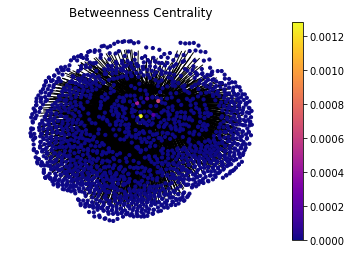

In [16]:
#9 Misure di centralità sul grafo completo
btw_centrality = nx.betweenness_centrality(sub_twitter_graph)
btw_centrality_sorted=sorted(btw_centrality.items(),key=lambda x:x[1],reverse=True)
print(btw_centrality_sorted[:6])
draw(sub_twitter_graph,nx.spring_layout(sub_twitter_graph),btw_centrality,'Betweenness Centrality')

[('132646210', 0.6531724406383806), ('19659370', 0.5960923623445826), ('15750573', 0.4769755542922115), ('18932422', 0.4765691564896336), ('3036907250', 0.45672291780076213), ('740410382', 0.0)]


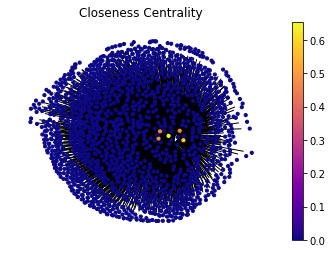

In [17]:
cls_centrality = nx.closeness_centrality(sub_twitter_graph)
cls_centrality_sorted = sorted(cls_centrality.items(),key=lambda x:x[1],reverse=True)
print(cls_centrality_sorted[:6])
draw(sub_twitter_graph,nx.spring_layout(sub_twitter_graph),cls_centrality,'Closeness Centrality')

[('132646210', 0.4713945172824791), ('19659370', 0.3235995232419547), ('15750573', 0.200834326579261), ('18932422', 0.09594755661501787), ('3036907250', 0.06317044100119189), ('94732055', 0.0023837902264600714)]


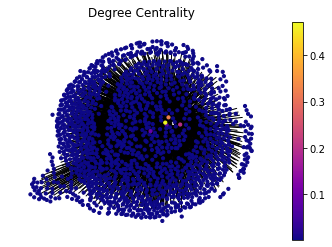

In [18]:
dg_centrality = nx.degree_centrality(sub_twitter_graph)
dg_centrality_sorted=sorted(dg_centrality.items(),key=lambda x:x[1],reverse=True)
print(dg_centrality_sorted[:6])
draw(sub_twitter_graph,nx.spring_layout(sub_twitter_graph),dg_centrality,'Degree Centrality')


[('132646210', 0.46901072705601904), ('19659370', 0.32240762812872464), ('15750573', 0.19904648390941596), ('18932422', 0.09415971394517282), ('3036907250', 0.06078665077473182), ('740410382', 0.0)]


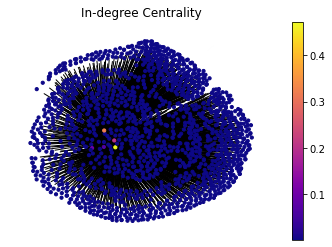

In [19]:
in_centrality= nx.in_degree_centrality(sub_twitter_graph)
in_centrality_sorted=sorted(in_centrality.items(),key=lambda x:x[1],reverse=True)
print(in_centrality_sorted[:6])
draw(sub_twitter_graph,nx.spring_layout(sub_twitter_graph),dg_centrality,'In-degree Centrality')

[('94732055', 0.0023837902264600714), ('14451127', 0.0023837902264600714), ('810893744593584128', 0.0023837902264600714), ('125483940', 0.0023837902264600714), ('2190533245', 0.0023837902264600714), ('3036907250', 0.0023837902264600714)]


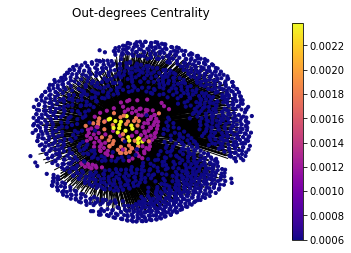

In [20]:
out_centrality= nx.out_degree_centrality(sub_twitter_graph)
out_centrality_sorted=sorted(out_centrality.items(),key=lambda x:x[1],reverse=True)
print(out_centrality_sorted[:6])
draw(sub_twitter_graph,nx.spring_layout(sub_twitter_graph),out_centrality,'Out-degrees Centrality')

[('132646210', 0.24344350091927122), ('19659370', 0.19459372341628542), ('18932422', 0.1712035495617394), ('3036907250', 0.13565158508066366), ('15750573', 0.10555433548306957)]


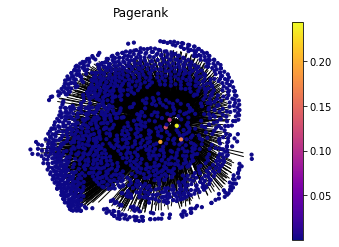

In [21]:
pagerank= nx.pagerank(sub_twitter_graph)
pagerank_sorted=sorted(pagerank.items(),key=lambda x:x[1],reverse=True)
print(pagerank_sorted[:5])
draw(sub_twitter_graph,nx.spring_layout(sub_twitter_graph),pagerank,'Pagerank')

[('94732055', 0.001547318026404474), ('14451127', 0.001547318026404474), ('810893744593584128', 0.001547318026404474), ('125483940', 0.001547318026404474), ('2190533245', 0.001547318026404474)]


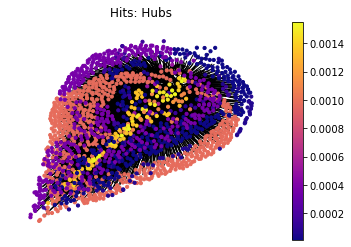

In [22]:
hits= nx.hits(sub_twitter_graph)
hits_hubs=hits[0]
hits_hub_sorted= sorted(hits_hubs.items(),key=lambda x:x[1],reverse=True)
print(hits_hub_sorted[:5])
draw(sub_twitter_graph,nx.spring_layout(sub_twitter_graph),hits_hubs,'Hits: Hubs')


[('132646210', 0.6243701263224811), ('19659370', 0.23790522256888028), ('18932422', 0.08980472460682286), ('3036907250', 0.03981708773451595), ('15750573', 0.008102838767299813)]


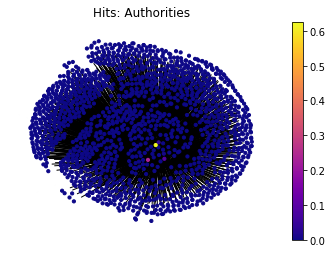

In [23]:
hits_authorities=hits[1]
hits_authorities_sorted=sorted(hits_authorities.items(),key=lambda x:x[1],reverse=True)
print(hits_authorities_sorted[:5])
draw(sub_twitter_graph,nx.spring_layout(sub_twitter_graph),hits_authorities,'Hits: Authorities')

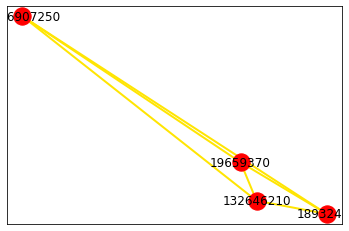

In [24]:
#Sottografo del nodo KevinRoitero
sub_graph_KevinRoitero = nx.ego_graph(undirected_sub_twitter_graph, "3036907250",radius=1)
max_cl= clique.max_clique(sub_graph_KevinRoitero)
clique_subgraph=undirected_sub_twitter_graph.subgraph(max_cl)
#print(max_cl)
nx.draw_networkx(
    clique_subgraph,
    pos=nx.spring_layout(sub_graph_KevinRoitero),
    node_color="#ff0000",
    edge_color="#ffe502",
    width=2,
    with_labels=True)
plt.show()
plt.close()

In [25]:
#11 copertua minima degli archi
nx.min_edge_cover(undirected_sub_twitter_graph)

{('19659370', '352650313'),
 ('256879792', '132646210'),
 ('132646210', '3243155048'),
 ('15750573', '1218287414965350401'),
 ('717348489215262724', '19659370'),
 ('19659370', '335829830'),
 ('78807415', '19659370'),
 ('19659370', '298982411'),
 ('132646210', '606214834'),
 ('934228950', '15750573'),
 ('746052642925740033', '132646210'),
 ('253609062', '19659370'),
 ('15750573', '540985738'),
 ('140093780', '18932422'),
 ('2206179206', '18932422'),
 ('13284672', '19659370'),
 ('1320513201071484928', '132646210'),
 ('132646210', '1169945329053130753'),
 ('19659370', '386277982'),
 ('15750573', '119406189'),
 ('250055606', '19659370'),
 ('716643191072628736', '19659370'),
 ('2900424513', '15750573'),
 ('15750573', '3197088767'),
 ('15750573', '1401748656'),
 ('386277982', '19659370'),
 ('15750573', '151581782'),
 ('37048037', '15750573'),
 ('19659370', '12151932'),
 ('2685989162', '132646210'),
 ('15750573', '577243493'),
 ('2544647385', '15750573'),
 ('1046614848', '132646210'),
 ('1965

In [ ]:
#12 Small-world-ness
omega=nx.omega(undirected_sub_twitter_graph, niter=15, nrand=4)
print(omega)
sigma=nx.sigma(undirected_sub_twitter_graph,niter=15, nrand=4)
print(sigma)

In [26]:
#13 Correlazione di Pearson e di Kendall
centralities= [btw_centrality_sorted,cls_centrality_sorted,dg_centrality_sorted,in_centrality_sorted,out_centrality_sorted]
columns=["name","value"]
centralita_df = pd.DataFrame(columns=columns)
rows = [["Betwenness",btw_centrality],["Closeness",cls_centrality],["Degree",dg_centrality],["In-Degree",in_centrality],["Out-Degree",out_centrality]]
#Creazione df contenente tipologia_misura : valore
for row in rows:
    centralita_df.loc[len(centralita_df)] = row


#Creazione df contenente  tipologia_misura_1 , tipologia_misura_2, valore_correlazione_1 , valore_correlazione_2
columns=["Valore 1","Valore 2","Correlazione di Pearson", "Correlazione di Kendall"]
result= pd.DataFrame(columns=columns)

for index, param_1 in centralita_df.iterrows():
    for index, param_2 in centralita_df.iterrows():
        if(param_1["name"] != param_2["name"]):
            name_1= param_1["name"]
            name_2= param_2["name"]
            array_1= np.array(list(param_1["value"].values()), dtype=float)
            array_2= np.array(list(param_2["value"].values()), dtype=float)
            pearson= stats.pearsonr(array_1,array_2)
            kendall= stats.kendalltau(array_1,array_2)
            new_row = {
            'Valore 1': name_1,
            'Valore 2': name_2,
            'Correlazione di Pearson': pearson,
            'Correlazione di Kendall': kendall
                }
            result = result.append(new_row, ignore_index=True)

result

,Valore 1,Valore 2,Correlazione di Pearson,Correlazione di Kendall
0,Betwenness,Closeness,"(0.8732833494380734, 0.0)","(1.0, 0.0)"
1,Betwenness,Degree,"(0.99153116582972, 0.0)","(0.17961083327934085, 8.841007564545347e-14)"
2,Betwenness,In-Degree,"(0.9916503555928056, 0.0)","(1.0, 0.0)"
3,Betwenness,Out-Degree,"(0.19279170603973841, 1.6029685105045891e-15)","(0.17110933835657438, 1.2355808256776152e-12)"
4,Closeness,Betwenness,"(0.8732833494380734, 0.0)","(1.0, 0.0)"
5,Closeness,Degree,"(0.9042051710016155, 0.0)","(0.17961083327934085, 8.841007564545347e-14)"
6,Closeness,In-Degree,"(0.9033016323580848, 0.0)","(1.0, 0.0)"
7,Closeness,Out-Degree,"(0.22811389307609925, 2.92986733423811e-21)","(0.17110933835657438, 1.2355808256776152e-12)"
8,Degree,Betwenness,"(0.99153116582972, 0.0)","(0.17961083327934088, 8.841007564545347e-14)"
9,Degree,Closeness,"(0.9042051710016155, 0.0)","(0.17961083327934088, 8.841007564545347e-14)"
